***София Поповичева***

Финальный проект по программе «Компьютерная лингвистика»

**«Автоматическая оценка лексической сложности англоязычных песен»**

Проект посвящён автоматической оценке сложности англоязычных песен на основе лексических характеристик текста. В работе был собран корпус текстов песен с сайта Amalgama, проведена их предобработка и лемматизация, после чего были рассчитаны статистические признаки текста и показатели, основанные на словарных уровнях CEFR. Цель проекта разработать способ автоматического определения уровня сложности песни и выделения наиболее сложной и полезной для изучения лексики.

**Цели и задачи:**
– собрать и подготовить корпус текстов песен;
– выполнить лемматизацию и очистку данных;
– извлечь статистические признаки текста;
– рассчитать показатели сложности на основе CEFR;
– объединить признаки и провести кластеризацию песен;
– реализовать демонстрационный поиск песни и вывод лексики.

**Результаты:**
В ходе работы были рассчитаны словарные признаки сложности, предложена модификация оценки уровня, а также выполнена кластеризация песен на три группы сложности. Дополнительно реализован демонстрационный модуль, позволяющий выбрать автора и песню и получить её тексты и список наиболее сложных слов.

**Проблемы и ограничения:**
Основная трудность заключалась в том, что используемый CEFR-словарь покрывает только уровни A1–B2, что ограничивает верхнюю границу оценки сложности. Кроме того, средний уровень лексики часто занижал итоговую оценку из-за высокой доли частотных слов, поэтому потребовалось использовать дополнительные показатели. В проекте не учитываются синтаксическая сложность и устойчивые выражения.

**Использованные инструменты:**
Python, pandas, nltk, scikit-learn, matplotlib, requests, BeautifulSoup, CEFR dataset.

Парсинг сайтов песен и сбор датасета с текстами (русский и английский)

In [4]:
# импорт бибилиотек
import requests # библиотека для работы с HTTP запросами 
from bs4 import BeautifulSoup # для работы с HTML (парсинг HTML)
import pandas as pd # импорт библиотеки для работы с таблицами
import time # для пауp между запросами
import re  # для работы с регулярными выражениями
from urllib.parse import urljoin # для правильного склеивания ссылок (базы и относительного пути)

In [8]:
# словарь (ключ - имена артистов, значение - ссылка на страницу с песнями)
artists = {
    "Adele": "https://www.amalgama-lab.com/songs/a/adele/",
    "Michael Jackson": "https://www.amalgama-lab.com/songs/m/michael_jackson/",
    "Imagine Dragons": "https://www.amalgama-lab.com/songs/i/imagine_dragons/",
    "K.Flay": "https://www.amalgama-lab.com/songs/k/k_flay/",
    "Katy Perry": "https://www.amalgama-lab.com/songs/k/katy_perry/",
    "Eminem": "https://www.amalgama-lab.com/songs/e/eminem/",
    "Arctic Monkeys": "https://www.amalgama-lab.com/songs/a/arctic_monkeys/",
    "Britney Spears": "https://www.amalgama-lab.com/songs/b/britney_spears/",
    "Billie Eilish": "https://www.amalgama-lab.com/songs/b/billie_eilish/",
    "The Beatles": "https://www.amalgama-lab.com/songs/b/beatles/",
    "Queen": "https://www.amalgama-lab.com/songs/q/queen/",
}

In [3]:
# функция для того, чтобы открыть html страницы 
TIMEOUT = 20 # максимальное время для ожидания запроса 
SLEEP_BETWEEN_REQUESTS = 0.6 # пауза между запросами

HEADERS = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/120.0 Safari/537.36"
} # тут я делаю запрос похожим на обычный запрос пользователя

def html_get(url):
    ''' Скачаивает HTML страницу и возвращает строку
    если вылезет ошибка, то покажет её и остановит запрос'''
    response = requests.get( # get отправляят запрос
        url, # сама ссылка 
        headers = HEADERS, # заголовки типа браузер
        timeout=    TIMEOUT # таймаут 
    )
    response.raise_for_status() # если статус не 200, то выводит ошибку
    response.encoding = response.apparent_encoding # позволяет заменить автоматически определённую кодировку на ту, что распознаёт свойство
    return response.text


In [5]:
# функция, которая открывает страницу артиста, находит список песен, собирает ссылки в целые и возвращает список песен

def get_song_links(artist_url):
    ''' получает ссылку на страницу с песнями артиста и возвращает ссылки на каждую песню'''
    html = html_get(artist_url) # скачиваю тсраницу артиста
    soup = BeautifulSoup(html, "html.parser") # первращаю в объект beautiful soup

    song_links = [] # сюда буду складывать ссылки на песни
    artist_block = soup.find("li", class_="active") # на странице в кода блок с артистом лежит под тегом # <li class="active">

    if artist_block is None:
        return song_links # если блок не найден, то возащает пустой список

    song_ul = artist_block.find_next_sibling("ul") # в следующем теге ul назодятся сами тексты песен
    if song_ul is None:
        return song_links

    for a in song_ul.find_all("a"): # тут ищу тег а
        href = a.get("href") # и получаю из этоготега значение
        if href and href.endswith(".html"): # если нашел тег href и этот тег заканчвается на html 
            full_url = urljoin(artist_url, href) # склеиваю относительную ссылку с базовой с помощью urljoin
            song_links.append(full_url) # добавляю полную ссылку в список
    
    return song_links
            

In [11]:
# функция, которая открывает станицу песни, берет заголовок, английский и русский тексты

def parse_song(song_url):
    ''' Принимает ссылка на старинцу песни из url_song и возвращает название песни, английский текст и русский перевод'''
    
    html = html_get(song_url) # скачаиваю url песни
    soup = BeautifulSoup(html, "html.parser")
    
    h2_en = soup.find("h2", class_="original") # нахожу заголовок оригинала, в коде страницы заголовки лежат вот так <h2 style="font-weight:bold;" class="original">Angeleyes <span>(оригинал ABBA)</span></h2>
    if h2_en:
        title_en = h2_en.find(string=True, recursive=False).strip() # если находит такой объект, то берет из негготолько текст заголовка без текста из span
    else:
        title_en = "" # если не нашел, то возвращает пустю строку
    
    h2_ru = soup.find("h2", class_="translate") # русский заголовок
    if h2_ru:
        title_ru = h2_ru.find(string=True, recursive=False).strip()
    else:
        title_ru = ""
    
    # теперь сами тексты песен 
    original_lines = [] # список строк оригинала на англ
    translation_lines = [] # список строк на русском
    
    for block in soup.find_all("div", class_="string_container"):
        
        orig = block.find("div", class_="original")
        tran = block.find("div", class_="translate")
        
        if orig:
            original_lines.append(orig.get_text(" ", strip=True))
            
        if tran:
            translation_lines.append(tran.get_text(" ", strip=True))
    
    original_text = "\n".join(original_lines).strip()
    translation_text = "\n".join(translation_lines).strip()
    
    return title_en, title_ru, original_text, translation_text
    

In [ ]:
url = "https://www.amalgama-lab.com/songs/a/abba/angeleyes.html"
title_en, title_ru, orig, tran = parse_song(url)

print(title_en, " / ", title_ru)
print(orig[:200])
print(tran[:200])


In [14]:
# функция берет ссылку на артиста, список ссылкок на его песни, заходит в каждую песню, достает текст
def scrape_artist(artist_name, artist_url):
    """ Парсит все песни одного ариста. Возвращает список словарей, где каждый словарь - это одна песня. 
    Каждый словарь содержит:
    - artist
    - song_url
    - title_en
    - title_ru
    - original_text
    - translation_text"""
    
    song_urls = get_song_links(artist_url)
    rows = []
    
    for i, song_url in enumerate(song_urls, start=1):
        time.sleep(SLEEP_BETWEEN_REQUESTS)
        
        try:
            title_en, title_ru, original_text, translation_text = parse_song(song_url)
            
            rows.append({
                "artist": artist_name,
                "song_url": song_url,
                "title_en": title_en,
                "title_ru": title_ru,
                "original_text": original_text,
                "translation_text": translation_text
            })
            
            print(f"[{artist_name}] {i}/{len(song_urls)} OK - {title_en}")
        
        except Exception as e:
            print(f"[{artist_name}] {i}/{len(song_urls)} ERROR - {song_url} - {e}")
            
    return rows            

In [ ]:
# сбор датасета
all_rows = [] # сюда добавляю резульаты по всем артистам

for artist_name, artist_url in artists.items():
    print("\n" + "="*60) # добавила разграничитель
    print(f"Начинаю парсить: {artist_name}")  # показываем, какого артиста сейчас парсим
    print(f"Ссылка: {artist_url}")  # чтобы было видно откуда парсим

    artist_rows = scrape_artist(artist_name, artist_url)
    all_rows.extend(artist_rows)

    print(f"Готово: {artist_name}. Добавлено песен: {len(artist_rows)}")
    
    # и схор. результаты
OUTPUT_CSV = "amalgama_songs_dataset.csv"  # имя файла, куда сохраним датасет
df.to_csv(
    OUTPUT_CSV,         # имя файла
    index=False,        
    encoding="utf-8-sig" 
)

print(f"Датасет сохранён в файл: {OUTPUT_CSV}") 


Начинаю парсить: Adele
Ссылка: https://www.amalgama-lab.com/songs/a/adele/
[Adele] 1/63 OK - All I Ask
[Adele] 2/63 OK - All Night Parking
[Adele] 3/63 OK - Best for Last
[Adele] 4/63 OK - Black & Gold*
[Adele] 5/63 OK - Can I Get It
[Adele] 6/63 OK - Can't Let Go
[Adele] 7/63 OK - Chasing Pavements
[Adele] 8/63 OK - Cold Shoulder
[Adele] 9/63 OK - Crazy for You
[Adele] 10/63 OK - Cry Your Heart Out
[Adele] 11/63 OK - Daydreamer
[Adele] 12/63 OK - Don't You Remember
[Adele] 13/63 OK - Easy on Me
[Adele] 14/63 OK - Fastlove*
[Adele] 15/63 OK - First Love
[Adele] 16/63 OK - Fool That I Am
[Adele] 17/63 OK - He Won't Go
[Adele] 18/63 OK - Hello
[Adele] 19/63 OK - Hiding My Heart*
[Adele] 20/63 OK - Hold On
[Adele] 21/63 OK - Hometown Glory
[Adele] 22/63 OK - I Can't Make You Love Me*
[Adele] 23/63 OK - I Drink Wine
[Adele] 24/63 OK - I Found a Boy
[Adele] 25/63 OK - I'll Be Waiting
[Adele] 26/63 OK - I Miss You
[Adele] 27/63 OK - If It Hadn't Been for Love
[Adele] 28/63 OK - Lay Me Down


,artist,song_url,title_en,title_ru,original_text,translation_text
0,Adele,https://www.amalgama-lab.com/songs/a/adele/all...,All I Ask,"Всё, о чем я прошу",[Verse 1:]\nI will leave my heart at the door\...,[Куплет 1:]\nЯ оставлю свое сердце на пороге.\...
1,Adele,https://www.amalgama-lab.com/songs/a/adele/all...,All Night Parking,Круглосуточная парковка,I know you've got things to do (I do too)\nI j...,"Я знаю, что у тебя есть дела, (у меня тоже)\nН..."
2,Adele,https://www.amalgama-lab.com/songs/a/adele/bes...,Best for Last,Лучшее напоследок,"Wait, do you see my heart on my sleeve?\nIt's ...","Погоди, видишь, сердце мое для тебя открыто?\n..."


In [5]:
import pandas as pd

df = pd.read_csv("amalgama_songs_dataset.csv", encoding="utf-8-sig")

print("Датасет загружен.")
print("Размер:", df.shape)

df.head(3)

Датасет загружен.
Размер: (1389, 6)


,artist,song_url,title_en,title_ru,original_text,translation_text
0,Adele,https://www.amalgama-lab.com/songs/a/adele/all...,All I Ask,"Всё, о чем я прошу",[Verse 1:]\nI will leave my heart at the door\...,[Куплет 1:]\nЯ оставлю свое сердце на пороге.\...
1,Adele,https://www.amalgama-lab.com/songs/a/adele/all...,All Night Parking,Круглосуточная парковка,I know you've got things to do (I do too)\nI j...,"Я знаю, что у тебя есть дела, (у меня тоже)\nН..."
2,Adele,https://www.amalgama-lab.com/songs/a/adele/bes...,Best for Last,Лучшее напоследок,"Wait, do you see my heart on my sleeve?\nIt's ...","Погоди, видишь, сердце мое для тебя открыто?\n..."


In [ ]:
print(df.sample(1)[["artist", "title_en", "title_ru"]])  # покажет общую информацию о случайной песни

         artist         title_en        title_ru
375  Katy Perry  One of the Boys  Один из парней


In [7]:
import random

random_row = df.sample(1).iloc[0] # выбираю случайную строку 

print("🎤 Артист:", random_row["artist"])
print("🎵 Название (EN):", random_row["title_en"])
print("🎵 Название (RU):", random_row["title_ru"])

print("\nORIGINAL\n")
print(random_row["original_text"])

print("\nTRANSLATIO\n")
print(random_row["translation_text"])


🎤 Артист: Arctic Monkeys
🎵 Название (EN): Red Light Indicates Doors Are Secured
🎵 Название (RU): Красная лампочка показывает, что двери заблокированы

ORIGINAL

[Verse 1:]
We'll ask if we can have six in,
If not, we'll have to have two.
Well, you're coming up at our end, aren't you?
So I'll get one with you.
Won't he let us have six in?
Especially not with the food.
He could have just told us no, though,
He didn't have to be rude.
You see her with the green dress?
She talked to me at the bar.
Well, how come it's already two-pound fifty,
We've only gone about a yard?
Didn't you see she were gorgeous?
She were beyond belief!
But this lad at the side drinking his Smirnoff Ice
Came and paid for her Tropical Reef.
[Chorus:]
And I'm sitting going backwards,
And I didn't want to leave.
I said "It's High Green, mate,
Via Hillsborough, please!"
[Verse 2:]
Well, how funny were that sketch earlier
Up near that taxi rank?
Oh no, you would have missed it,
Think it were when you went to the bank.
Th

Подготовка текста

Лемматизация

In [41]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

lemmatizer = WordNetLemmatizer()
stop_w = set(stopwords.words('english'))

def lemmatize_song(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_w]
    lemmas = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmas

In [112]:
df["lemmas"] = df["original_text"].apply(lemmatize_song) # примиеняю лемматизацию к моему датасету

In [113]:
df[["artist", "title_en", "lemmas"]].head(3) # и просматриваю, что получилось

,artist,title_en,lemmas
0,Adele,All I Ask,"[verse, leave, heart, door, wo, say, word, sai..."
1,Adele,All Night Parking,"[know, got, thing, want, spend, time, feel, go..."
2,Adele,Best for Last,"[wait, see, heart, sleeve, day, end, waiting, ..."


In [114]:
df.to_pickle("amalgama_songs_with_lemmas.pkl")
df = pd.read_pickle("amalgama_songs_with_lemmas.pkl") # сохраняю  список

In [115]:
df["n_tokens"] = df["lemmas"].apply(len) # общее кол-во слов в песне
df["n_unique"] = df["lemmas"].apply(lambda x: len(set(x))) # уникальные лсова
df["ttr"] = df["n_unique"] / df["n_tokens"] # Type token ratio -- уникальные слова / общее количество слов, доля уникальных слов
df["avg_word_len"] = df["lemmas"].apply(lambda x: sum(len(w) for w in x) / len(x) if len(x) else 0) # средняя длина слов

In [116]:
df[["artist", "title_en", "n_tokens", "n_unique", "ttr", "avg_word_len"]].head(6)

,artist,title_en,n_tokens,n_unique,ttr,avg_word_len
0,Adele,All I Ask,223,61,0.273543,4.551570
1,Adele,All Night Parking,69,52,0.753623,4.710145
2,Adele,Best for Last,160,88,0.550000,4.706250
3,Adele,Black & Gold*,134,56,0.417910,4.910448
4,Adele,Can I Get It,74,56,0.756757,4.500000
5,Adele,Can't Let Go,131,59,0.450382,4.435115


In [117]:
df[["n_tokens", "n_unique", "ttr", "avg_word_len"]].describe() # общая статистика

,n_tokens,n_unique,ttr,avg_word_len
count,1389.000000,1389.000000,1389.000000,1389.000000
mean,195.390209,92.149028,0.493783,4.782630
std,166.638149,92.149516,0.183887,0.445839
min,8.000000,4.000000,0.040237,2.930233
25%,96.000000,44.000000,0.357143,4.500000
50%,139.000000,61.000000,0.493976,4.764706
75%,231.000000,86.000000,0.630435,5.047794
max,1909.000000,1197.000000,1.000000,7.200000


In [118]:
row = df.sort_values("n_tokens", ascending=True).iloc[0] # смотрю экстремальые значения по тексту (тут самое маленькое, но можно поменять ascending на Flase)

print("Артист:", row["artist"])
print("Название:", row["title_en"])
print("n_tokens:", row["n_tokens"])
print("ttr:", row["ttr"])

print("\n--- ORIGINAL ---\n")
print(row["original_text"][:1500])  # первые 1500 символов

Артист: The Beatles
Название: Why Don't We Do It in the Road
n_tokens: 8
ttr: 0.5

--- ORIGINAL ---

[3x:]
Why don't we do it in the road
Why don't we do it in the road
Why don't we do it in the road
Why don't we do it in the road
No one will be watching us
Why don't we do it in the road


In [119]:
df_filtered = df[(df["n_tokens"] < 1000) & (df["n_tokens"] > 15)].copy() # тут я создаю копию датафрейма без экстремально длинных и коротких текстов (был тескт Эминенма почти на 2000 слов)

df_filtered["long_word_ratio"] = df_filtered["lemmas"].apply(
    lambda xs: sum(len(w) >= 6 for w in xs) / len(xs) if len(xs) else 0
) # решила добавить признак для длинных слов (больше 6 символов), считаю по леммам. и если в список пустой, то ставлю 0, чтобы не делить на  пустой список (0) 

features = df_filtered[["n_tokens", "ttr", "avg_word_len", "long_word_ratio"]].copy() # делаю копию датафрейма с нужными мне признаками

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # и нормализирую значения
scaled_features = scaler.fit_transform(features)

from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # кластеризирую , у меня три уровня сложности тестов, поэтому делаю три кластера


df_filtered["cluster"] = kmeans.fit_predict(scaled_features) # записываю кластеры в df_filtered

df_filtered.groupby("cluster")[["n_tokens", "ttr", "avg_word_len", "long_word_ratio"]].mean() # просматриваю средние значения по кластерам

,n_tokens,ttr,avg_word_len,long_word_ratio
cluster,,,,
0,474.366197,0.562570,4.911602,0.309780
1,124.207469,0.582989,5.168103,0.362219
2,151.069016,0.408852,4.469734,0.206075


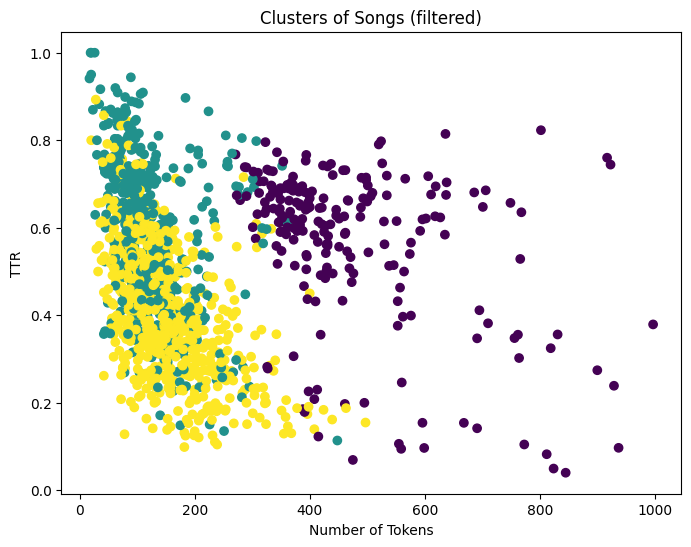

In [120]:
# рисую график
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_filtered["n_tokens"], df_filtered["ttr"], c=df_filtered["cluster"])
plt.xlabel("Number of Tokens")
plt.ylabel("TTR")
plt.title("Clusters of Songs (filtered)")
plt.show()

Я провела кластеризацию текстов песен с помощью алгоритма KMeans (3 кластера) на основе следующих признаков: общее количество слов в тексте (n_tokens), коэффициент лексического разнообразия (TTR), средняя длина слова и доля длинных слов (≥ 6 символов). Перед кластеризацией данные были нормализованы. В результате модель выделила три группы текстов. 

**Первый кластер** включает более длинные тексты со средним уровнем разнообразия лексики и может условно рассматриваться как тексты среднего уровня сложности. 

**Второй кластер** содержит относительно короткие тексты с высоким TTR и большей долей длинных слов, поэтому можно предположить более высокую лексическую насыщенность. 

**Третий кластер** включает тексты с более низким разнообразием лексики и меньшей долей длинных слов, что может свидетельствовать о более простом характере языка и высокой повторяемости. Хочу отметить, что текущая модель основана только на статистических показателях и не учитывает реальный уровень владения языком. 

Для более точной оценки сложности длаьше буду дополнительно использовать CEFR-словарь и рассчитывать распределение слов по уровням.

In [162]:
# загружаю подготовленный датасет с лексикой распределённой по уровням
cefr = pd.read_csv('word_list_cefr.csv', sep=";") # в датасете значения через ;

cefr = cefr[["headword", "CEFR"]].copy() # оставляю только нужные колонки
cefr.columns = ["word", "level"]
cefr["word"] = cefr["word"].str.lower()
cefr.head()

,word,level
0,a,A1
1,a.m.,A1
2,a.m.,A1
3,abandon,B1
4,abandoned,B2


In [122]:
# и создаю словарь
cefr_dict = dict(zip(cefr["word"], cefr["level"]))
cefr_dict.get("love") # проверяю, что покажет

'A1'

In [123]:
# некоторые слова встречаются несколько раз и срзаными уровнями, поэтому решила приравнять их меньшему уровню и отчистить копии
level_order = {"A1":1,"A2":2,"B1":3,"B2":4,"C1":5,"C2":6}

cefr["level_num"] = cefr["level"].map(level_order)

cefr_clean = (
    cefr.sort_values("level_num")
        .drop_duplicates("word", keep="first")
)

cefr_dict = dict(zip(cefr_clean["word"], cefr_clean["level"]))

In [124]:
cefr_clean["word"].value_counts().head(4) # проверяю остались ли копии

word
absentee    1
yours       1
your        1
young       1
Name: count, dtype: int64

Функция, которая считает примерный CEFR для одной песни

In [ ]:
def cefr_stats_for_lemmas(lemmas, cefr_dict, level_order):
    
    levels = [cefr_dict.get(w) for w in lemmas] # прохожу по каждой лемме и оставляю только те слова, которые есть в CEFR словаре
    levels = [lvl for lvl in levels if lvl is not None]  # убираю None, т.е. неизвестные слова
    
    coverage = len(levels) / len(lemmas) # это доля слов, которые вообще нашлись в словаре по отоношению к количепсвту слов, которые изначально были в песне (чем выше coverage, тем лучше)

    
    if len(lemmas) == 0: # защищаюсь от деления на ноль
        return {
            "cefr_coverage": 0.0,
            "cefr_mean_level_num": None,
            "cefr_mean_level": None,
            "cefr_p90_level_num": None,
            "cefr_p90_level": None,
            "cefr_top10_mean_num": None,
            "cefr_top10_mean_level": None,
            "share_A1": 0.0, "share_A2": 0.0, "share_B1": 0.0,
            "share_B2": 0.0, "share_C1": 0.0, "share_C2": 0.0,
        }

    if not levels: # если ничего не нашлось,то возвращаю нули (кака бы пусутю статистику)
        return {
            "cefr_coverage": 0.0,
            "cefr_mean_level_num": None,
            "cefr_mean_level": None,
            "cefr_p90_level_num": None, # дополнитлеьные метрики
            "cefr_p90_level": None,
            "cefr_top10_mean_num": None,
            "cefr_top10_mean_level": None,
            "share_A1": 0.0, "share_A2": 0.0, "share_B1": 0.0,
            "share_B2": 0.0, "share_C1": 0.0, "share_C2": 0.0,
        }

    
    level_nums = [level_order[lvl] for lvl in levels] # перевожу уровни в числа, где A1 = 1, а С2 = 6
    mean_num = sum(level_nums) / len(level_nums)    # среднее арифметическое по словам (еоторые нашлись в словаре)

    rounded = int(round(mean_num)) # округляю средний уровень до ближайшего (1..6)
    inv_level_order = {v: k for k, v in level_order.items()} # и обратно перевожу число в строковый уровень (A1..C2)
    mean_level = inv_level_order.get(rounded) # и округляю к ближайшему целому числу

    level_nums_sorted = sorted(level_nums)

    # p90 уровень "сложного хвоста" (примерно самые сложные 10% слов)
    idx = int(0.9 * (len(level_nums_sorted) - 1)) # 90 перцентиль и среднее по самым сложным 10% словам
    p90_num = level_nums_sorted[idx]
    p90_level = inv_level_order.get(p90_num)

    # top10_mean средний уровень по самым сложным 10% словам
    k = max(1, int(len(level_nums_sorted) * 0.10))  # хотя бы 1 слово
    top10 = level_nums_sorted[-k:]
    top10_mean_num = sum(top10) / len(top10)
    top10_mean_level = inv_level_order.get(int(round(top10_mean_num)))

    total = len(levels) # Общее число известных CEFR-слов в песне
    shares = {f"share_{lvl}": levels.count(lvl) / total for lvl in level_order.keys()} # и считаю долю каждого уровня среди найденных слов

    return {
        "cefr_coverage": coverage,
        "cefr_mean_level_num": mean_num,
        "cefr_mean_level": mean_level,
        "cefr_p90_level_num": p90_num,
        "cefr_p90_level": p90_level,
        "cefr_top10_mean_num": top10_mean_num,
        "cefr_top10_mean_level": top10_mean_level,
        **shares
    }

In [126]:
# тут применяю функцию к каждой песне в датафрейме
cefr_features = df["lemmas"].apply(lambda x: cefr_stats_for_lemmas(x, cefr_dict, level_order))
cefr_features_df = pd.DataFrame(list(cefr_features))

for col in cefr_features_df.columns:
    df[col] = cefr_features_df[col]

In [127]:
df[["artist", "title_en", "cefr_coverage", "cefr_mean_level", "cefr_p90_level", "cefr_top10_mean_level", "share_A1", "share_B2"]].head(10)

,artist,title_en,cefr_coverage,cefr_mean_level,cefr_p90_level,cefr_top10_mean_level,share_A1,share_B2
0,Adele,All I Ask,0.883408,A1,A2,B1,0.817259,0.020305
1,Adele,All Night Parking,0.927536,A1,A2,B1,0.734375,0.031250
2,Adele,Best for Last,0.831250,A1,A2,B1,0.766917,0.007519
3,Adele,Black & Gold*,0.858209,A1,A2,B1,0.686957,0.043478
4,Adele,Can I Get It,0.932432,A2,B1,B2,0.710145,0.072464
5,Adele,Can't Let Go,0.625954,A1,A2,B2,0.804878,0.073171
6,Adele,Chasing Pavements,0.842105,A2,B1,B2,0.575000,0.075000
7,Adele,Cold Shoulder,0.888889,A1,A2,B1,0.812500,0.000000
8,Adele,Crazy for You,0.769231,A2,B1,B2,0.550000,0.066667
9,Adele,Cry Your Heart Out,0.864198,A1,B1,B2,0.742857,0.057143


In [128]:
df.sort_values("cefr_top10_mean_num", ascending=False)[
    ["artist","title_en","cefr_top10_mean_num","cefr_top10_mean_level","cefr_mean_level_num","cefr_mean_level","cefr_coverage"]
].head(20)

,artist,title_en,cefr_top10_mean_num,cefr_top10_mean_level,cefr_mean_level_num,cefr_mean_level,cefr_coverage
1345,Queen,Seven Seas of Rhye,4.0,B2,2.000000,A2,0.815789
1385,Queen,You Don't Fool Me,4.0,B2,1.650000,A2,0.550459
1297,Queen,Killer Queen,4.0,B2,1.907692,A2,0.550847
1342,Queen,Scandal,4.0,B2,1.879518,A2,0.830000
388,Katy Perry,Self Inflicted,4.0,B2,1.811321,A2,0.785185
589,Eminem,Rap God,4.0,B2,1.773408,A2,0.695312
82,Michael Jackson,Childhood,4.0,B2,1.662162,A2,0.840909
77,Michael Jackson,Blue Gangsta,4.0,B2,1.544554,A2,0.631250
1207,The Beatles,Words of Love,4.0,B2,1.517241,A2,1.000000
1203,The Beatles,While My Guitar Gently Weeps,4.0,B2,1.681818,A2,0.721311


**Оценка лексической сложности по CEFR**

На этом этапе я рассчитала для каждой песни показатели, основанные на CEFR-словаре (A1–B2). Для каждой леммы проверялось, присутствует ли она в словаре, после чего определялись: доля покрытых слов (cefr_coverage), средний уровень лексики (cefr_mean_level), распределение слов по уровням, а также два дополнительных показателя — cefr_p90_level и cefr_top10_mean_level.

Среднее значение чаще всего оказывается A1–A2, что объясняется большим количеством частотной лексики в текстах песен. Поэтому дополнительно используется 90-й перцентиль и средний уровень самых сложных 10% слов. Эти показатели позволяют учитывать «лексический хвост» текста — то есть наличие более редкой и сложной лексики, которая может быть важной для оценки общей трудности песни.
 Далее полученные CEFR-показатели я буду объединять со статистическими признаками текста (длина, разнообразие слов и др.) для более комплексной классификации песен по уровню сложности.

Кластеризация с новыми признаками

In [131]:
# беру обновленные признаки
feature_cols = [
    "n_tokens",               # длина текста
    "ttr",                    # разнообразие лексики (unique/total)
    "avg_word_len",           
    "long_word_ratio",        # доля длинных слов
    "cefr_coverage",          # доля лемм, найденных в CEFR-словаре
    "cefr_top10_mean_num",    # средний уровень самых сложных 10% слов
    "share_B2"                # доля слов уровня B2 среди найденных
]
if "long_word_ratio" not in df.columns:
    df["long_word_ratio"] = df["lemmas"].apply(
        lambda xs: sum(len(w) >= 6 for w in xs) / len(xs) if len(xs) else 0
    )

df_clust = df.copy()  # копия датафрейма для кластеризации
df_clust = df_clust.dropna(subset=feature_cols)  # выбрасываю строки с NaN в признаках
X = df_clust[feature_cols].values  # массив признаков

In [ ]:
print(df.columns.tolist()) # вышло, что одного признака не хватало, проверяю, что все нужные признаки на месте

['artist', 'song_url', 'title_en', 'title_ru', 'original_text', 'translation_text', 'lemmas', 'n_tokens', 'n_unique', 'ttr', 'avg_word_len', 'cluster', 'cefr_coverage', 'cefr_mean_level_num', 'cefr_mean_level', 'cefr_p90_level_num', 'cefr_p90_level', 'cefr_top10_mean_num', 'cefr_top10_mean_level', 'share_A1', 'share_A2', 'share_B1', 'share_B2', 'share_C1', 'share_C2', 'long_word_ratio']


In [133]:
# создаю scaler, чтобы привести признаки к одному масштабу
scaler = StandardScaler()  # объект стандартизации
X_scaled = scaler.fit_transform(X)  # обучаю scaler и трансформирую признаки
k = 3  # количество кластеров
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # кластеризация
# обучаю модель и получаю метки кластеров для каждой песни
df_clust["cluster_all"] = kmeans.fit_predict(X_scaled)  # новый столбец с кластером

In [134]:
df["cluster_all"] = None  # создаю/обнуляю колонку в исходном df
# записываю кластеры только для тех строк, которые участвовали в кластеризации
df.loc[df_clust.index, "cluster_all"] = df_clust["cluster_all"]  # перенос меток в df

In [135]:
# смотрю средние значения признаков внутри каждого кластера

cluster_profile = df_clust.groupby("cluster_all")[feature_cols].mean() # средние по признакам
cluster_sizes = df_clust["cluster_all"].value_counts().sort_index() # сколько песен в каждом кластере

print("Размеры кластеров (кол-во песен):")
print(cluster_sizes)
print("\nСредние значения признаков по кластерам:")
display(cluster_profile)

Размеры кластеров (кол-во песен):
cluster_all
0    369
1    599
2    421
Name: count, dtype: int64

Средние значения признаков по кластерам:


,n_tokens,ttr,avg_word_len,long_word_ratio,cefr_coverage,cefr_top10_mean_num,share_B2
cluster_all,,,,,,,
0,348.601626,0.560330,4.856813,0.297816,0.671630,3.789439,0.091288
1,151.121870,0.405978,4.463119,0.201159,0.786693,2.773733,0.018684
2,124.087886,0.560386,5.172212,0.365697,0.760775,3.233111,0.036994


In [136]:
# смотрю несколько песен из каждого кластера
df_clust.sort_values(["cluster_all", "cefr_top10_mean_num"], ascending=[True, False])[
    ["cluster_all", "artist", "title_en", "cefr_top10_mean_level", "cefr_top10_mean_num", "ttr", "n_tokens", "cefr_coverage"]
].groupby("cluster_all").head(10)

,cluster_all,artist,title_en,cefr_top10_mean_level,cefr_top10_mean_num,ttr,n_tokens,cefr_coverage
56,0,Adele,To Be Loved,B2,4.000000,0.500000,160,0.787500
58,0,Adele,Water under the Bridge,B2,4.000000,0.266667,180,0.683333
77,0,Michael Jackson,Blue Gangsta,B2,4.000000,0.350000,160,0.631250
112,0,Michael Jackson,(I Like) the Way You Love Me,B2,4.000000,0.398058,103,0.650485
130,0,Michael Jackson,Money,B2,4.000000,0.508475,177,0.903955
132,0,Michael Jackson,Morning Glow,B2,4.000000,0.558140,86,0.895349
144,0,Michael Jackson,Scream,B2,4.000000,0.439130,230,0.560870
147,0,Michael Jackson,Shout,B2,4.000000,0.781250,192,0.734375
197,0,Imagine Dragons,Boomerang,B2,4.000000,0.311594,138,0.811594
213,0,Imagine Dragons,Emma,B2,4.000000,0.541667,72,0.611111


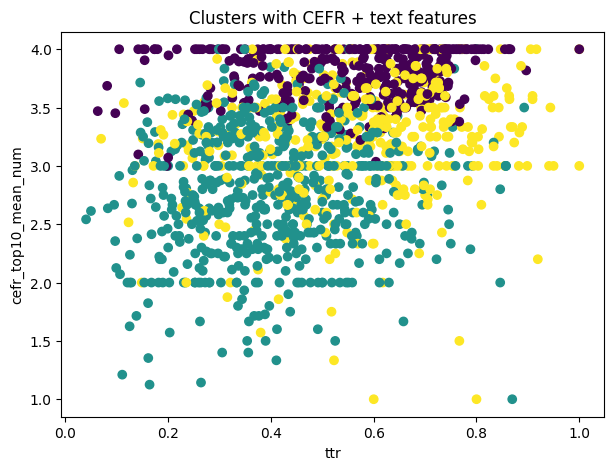

In [140]:
# визуализация 
plt.figure(figsize=(7, 5))  # размер графика
plt.scatter(df_clust["ttr"], df_clust["cefr_top10_mean_num"], c=df_clust["cluster_all"])  # точки
plt.xlabel("ttr")  # подпись оси X
plt.ylabel("cefr_top10_mean_num")  # подпись оси Y
plt.title("Clusters with CEFR + text features")  # заголовок
plt.show()  # показываю график

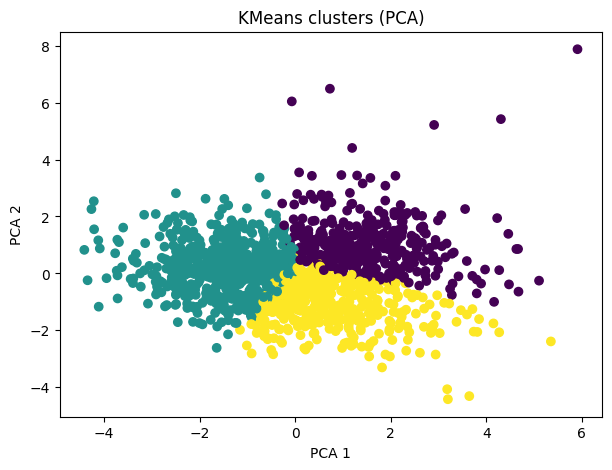

In [141]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=df_clust["cluster_all"])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("KMeans clusters (PCA)")
plt.show()

**Кластеризация по объединённым признакам (статистика + CEFR).**
Далее я объединила формальные признаки текста (длина, разнообразие лексики и т.п.) и CEFR-показатели (покрытие словаря, доля B2-слов и уровень сложного хвоста cefr_top10_mean_num) и повторила KMeans-кластеризацию на 3 группы. По средним значениям признаков кластеры интерпретируются как разные уровни сложности: кластер 1 выглядит самым простым (низкий cefr_top10_mean_num, минимальная доля B2 и низкий TTR), кластер 2 промежуточным (выше разнообразие и доля длинных слов), а кластер 0 самым сложным (максимальный “хвост” по CEFR, больше B2 лексики и самые длинные тексты). Эти три кластера можно соотнести с уровнями easy / medium / hard.

**PCA-визуализация кластеров.**
Поскольку кластеризация делалась по нескольким признакам одновременно, я дополнительно визуализировала результат с помощью PCA (это проекция многомерного пространства признаков на 2 измерения (PCA 1 и PCA 2), которая сохраняет максимальную часть разнообразия данных). На графике видно, что кластеры разделяются достаточно отчётливо, то есть выбранные признаки действительно дают устойчивые группы песен по сложности.

Интерактивный блок для поиска песни и небольшого анализа текста.

In [163]:
cluster_name = {1: "easy", 2: "medium", 0: "hard"} # соответствие номера кластера и текстовой метки сложности

In [ ]:
from collections import Counter # для счёта слов

def norm_text(s):
    return str(s).strip().lower() # чтобы можно было считать любой ввод пользователя

# ищу артистов, которые подходят под ввод пользователя
def find_artist(df, artist_query):
    mask = df["artist"].astype(str).str.lower().str.contains(norm_text(artist_query), na=False)
    return df[mask].copy() # и возвращаю отфильтрованный массив артистов, которые подходят

# нахожу песни у выбранного артиста
def find_song(df_artist, song_query):
    mask = df_artist["title_en"].astype(str).str.lower().str.contains(norm_text(song_query), na=False)
    return df_artist[mask].copy()

# и тут достаю лексику B1 и B2 
def hard_vocab_from_lemmas(lemmas, cefr_dict, hard_levels=("B2", "B1"), top_n=30):
    hard = [w for w in lemmas if cefr_dict.get(w) in hard_levels]  # оставляю только слова нужных ("сложных") уровней
    return Counter(hard).most_common(top_n)  # топ слов и  их частота

# вывожу одну выбранную песню
def show_song_info(row, cefr_dict):
    print(f"ARTIST: {row['artist']}")
    print(f"SONG:   {row['title_en']}")
    print(f"CEFR top10: {row.get('cefr_top10_mean_level')} | coverage: {row.get('cefr_coverage')}")
    print("\nEnglish\n")
    print(row.get("original_text", ""))
    print("\nРусский\n")
    print(row.get("translation_text", ""))

    lemmas = row.get("lemmas", [])
    hard_words = hard_vocab_from_lemmas(lemmas, cefr_dict, hard_levels=("B2", "B1"), top_n=30)

    print("\nПолезная лексика")
    if len(hard_words) == 0:
        print("Слов уровня B1-B2 не нашлось.")
    else:
        for w, c in hard_words:
            print(f"{w} — {c}")



artist_query = input(" Введи артиста (например, Eminem): ")
df_artist = find_artist(df, artist_query)

if len(df_artist) == 0:
    print("Нет такого артиста. Попробуй другое написание.")
else:
    titles = sorted(df_artist["title_en"].dropna().unique().tolist())
    print(f"\nНайдено {len(titles)} песен. Примеры:")
    for t in titles[:30]:
        print("-", t)

    song_query = input("\nВведи название песни: ")
    df_song = find_song(df_artist, song_query)

    if len(df_song) == 0:
        print("Нет такой песни. Попробуй по-другому.")
    else:
        df_song = df_song.reset_index(drop=True)

        print(f"\nНайдено {len(df_song)} совпадений, выбери один вариант:")
        for i, row in df_song.iterrows():
            print(f"[{i}] {row['artist']} — {row['title_en']}")

        choice = input("\nВведи номер (Enter = 0): ").strip()
        idx = int(choice) if choice.isdigit() else 0
        idx = max(0, min(idx, len(df_song) - 1))

        show_song_info(df_song.loc[idx], cefr_dict)


Нашла 121 песен. Примеры (первые 30):
- (I Like) the Way You Love Me
- 2 Bad
- ABC
- All I Need
- Another Day
- Another Part of Me
- Baby Be Mine
- Bad
- Beat It
- Behind the Mask
- Ben
- Best of Joy
- Billie Jean
- Black Or White
- Blood on the Dancefloor
- Blue Gangsta
- Breaking News
- Butterflies
- Butterflies (Master Mix)
- Can't Let Her Get Away
- Childhood
- Come Together
- Cry
- D.S.
- Dangerous
- Dear Michael
- Dirty Diana
- Do You Know Where Your Children Are
- Don't Stop Till You Get Enough
- Don't Walk Away

Найдено 1 совпадений, выбери один вариант:
[0] Michael Jackson — Smooth Criminal
ARTIST: Michael Jackson
SONG:   Smooth Criminal
CEFR top10: B1 | coverage: 0.5675675675675675

English

As he came into the window
It was the sound of a crescendo
He came into her apartment
He left the bloodstains on the carpet
She ran underneath the table
He could see she was unable
So she ran into the bedroom
She was struck down, it was her doom
Annie are you ok?
So, Annie are you ok
Are